In [34]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import ImageEnhance, ImageOps
from mtcnn import MTCNN
from mtcnn.mtcnn import MTCNN
import cv2
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm


In [ ]:
data_dir = "data"
categories = ["criminal", "non-criminal"]

# Detector
detector = MTCNN()

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


## Show Data Image (Criminal & Non-criminal)

In [36]:
def show_all_data(categories, max_per_cat=5):
    all_images = []
    labels = []

    for category in categories:
        folder = os.path.join(data_dir, category)

        img_files = []
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_files.append(os.path.join(root, f))

        # Random sample
        img_files = random.sample(img_files, min(max_per_cat, len(img_files)))

        # Append to list
        all_images.extend(img_files)
        labels.extend([category] * len(img_files))

    # Show horizontally
    plt.figure(figsize=(20, 5))
    for idx, (img_path, label) in enumerate(zip(all_images, labels)):
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            continue
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(all_images), idx+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

    plt.suptitle("All Categories - Original Images", fontsize=16)
    plt.tight_layout()
    plt.show()

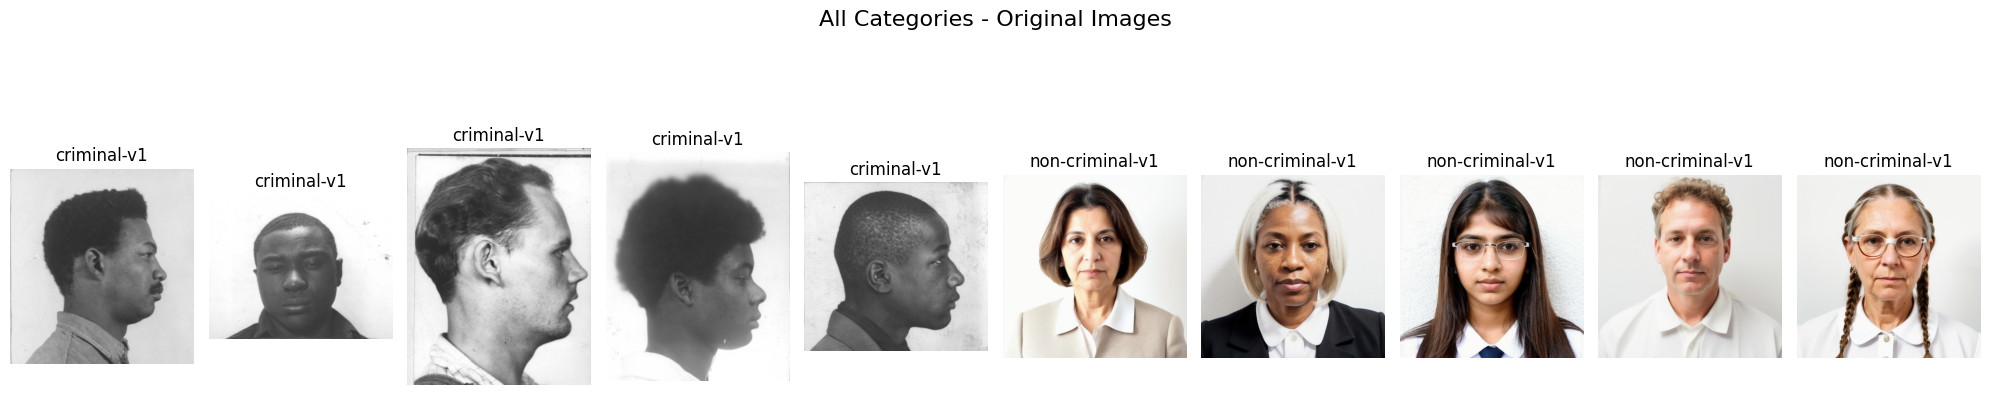

In [37]:
show_all_data(categories, max_per_cat=5)

## Show MTCNN Results (Criminal & Non-criminal)

In [38]:
def show_all_data_mtcnn(categories, max_per_cat=5):
    all_images = []
    labels = []

    for category in categories:
        folder = os.path.join(data_dir, category)

        img_files = []
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_files.append(os.path.join(root, f))

        img_files = random.sample(img_files, min(max_per_cat, len(img_files)))

        # Append to list
        all_images.extend(img_files)
        labels.extend([category] * len(img_files))

    # Show horizontally
    plt.figure(figsize=(20, 5))
    for idx, (img_path, label) in enumerate(zip(all_images, labels)):
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            continue
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Detect faces
        results = detector.detect_faces(image)

        # Draw bounding boxes
        for res in results:
            x, y, w, h = res['box']
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            confidence = res['confidence']
            cv2.putText(image, f"{confidence:.2f}", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        plt.subplot(1, len(all_images), idx+1)
        plt.imshow(image)
        plt.title(f"{label}\nFaces: {len(results)}")
        plt.axis("off")

        print(f"File: {os.path.basename(img_path)} | Category: {label} | Faces detected: {len(results)}")

    plt.suptitle("All Categories - MTCNN Results", fontsize=16)
    plt.tight_layout()
    plt.show()

File: 00007_3_F.png | Category: criminal-v1 | Faces detected: 0
File: 00017_2_R.png | Category: criminal-v1 | Faces detected: 0
File: 00004_1_R.png | Category: criminal-v1 | Faces detected: 0
File: 00005_1_F.png | Category: criminal-v1 | Faces detected: 1
File: 00018_1_R.png | Category: criminal-v1 | Faces detected: 1
File: S41753161-GF-A23-EAF-T03-S1-LH-C1-I0006-F00.png | Category: non-criminal-v1 | Faces detected: 1
File: S9176807-GM-A21-EEA-T03-S1-LH-C1-I0003-F00.png | Category: non-criminal-v1 | Faces detected: 1
File: S43189665-GF-A47-EME-T13-S1-LH-C1-I0027-F00.png | Category: non-criminal-v1 | Faces detected: 1
File: S19423222-GM-A45-EAF-T14-S1-LH-C1-I0002-F00.png | Category: non-criminal-v1 | Faces detected: 1
File: S18796367-GF-A93-EAF-T00-S1-LH-C1-I0007-F00.png | Category: non-criminal-v1 | Faces detected: 1


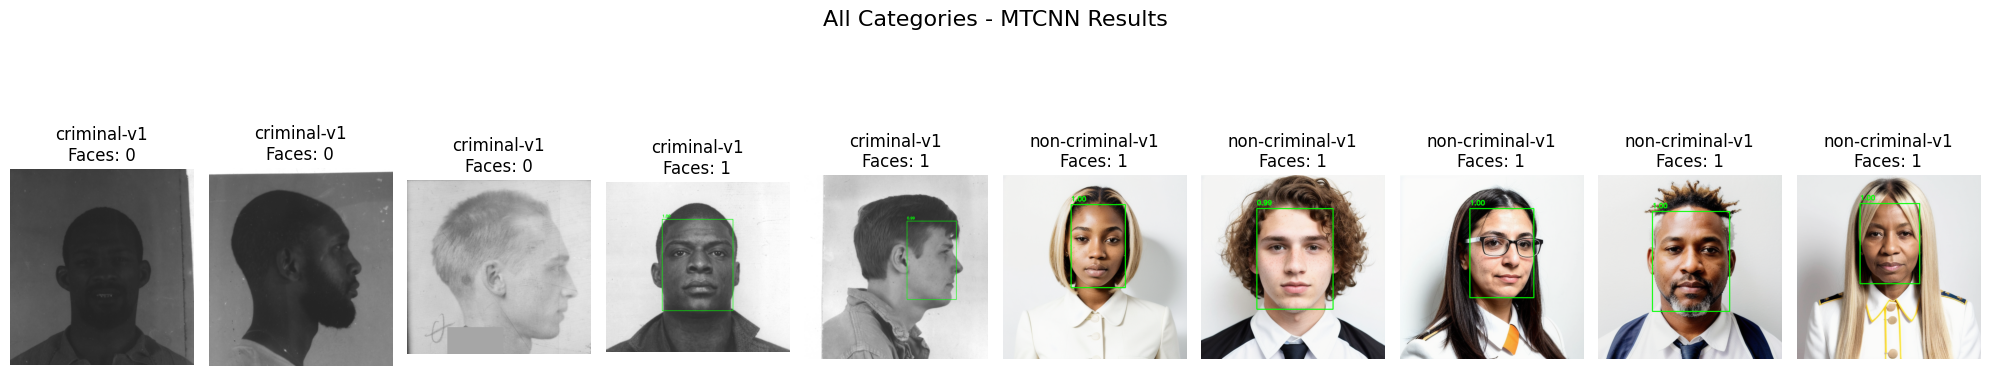

In [39]:
show_all_data_mtcnn(categories, max_per_cat=5)

In [40]:
def process_mtcnn_preprocessing(categories, target_size=(64,64)):
    images = []
    labels = []

    for label, category in enumerate(categories):
        folder = os.path.join(data_dir, category)

        img_files = []
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_files.append(os.path.join(root, f))

        # Loop images
        for img_path in img_files:
            image_bgr = cv2.imread(img_path)
            if image_bgr is None:
                continue
            image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

            # Detect faces
            results = detector.detect_faces(image)

            # Only keep if exactly 1 face detected
            if len(results) == 1:
                x, y, w, h = results[0]['box']
                face = image[y:y+h, x:x+w]

                # Resize + grayscale
                face_resized = cv2.resize(face, target_size)
                face_gray = cv2.cvtColor(face_resized, cv2.COLOR_RGB2GRAY)

                images.append(face_gray)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [41]:
images, labels = process_mtcnn_preprocessing(categories, target_size=(64,64))
print(f"✅ Total preprocessed images: {len(images)}")

✅ Total preprocessed images: 194


## Preprocessing

In [42]:
def show_preprocessed_samples(images, labels, categories, n=10):
    plt.figure(figsize=(15,3))
    indices = np.random.choice(len(images), min(n, len(images)), replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx].squeeze(), cmap="gray")
        plt.title(categories[labels[idx]])
        plt.axis("off")
    plt.show()

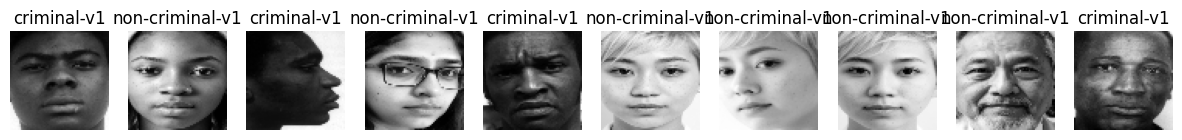

In [43]:
# Show random samples
show_preprocessed_samples(images, labels, categories, n=10)

## Generative Adversarial Networks (GAN)

In [46]:
# ====================================
# Step 5: Persiapan Data untuk GAN
# ====================================
# Variabel asli dari preprocessing = images
processed_images = images  

if len(processed_images.shape) == 3:   # (n, h, w)
    processed_images = np.expand_dims(processed_images, -1)

# Resize ke 128x128 agar sesuai arsitektur GAN
processed_images = tf.image.resize(processed_images, [128,128])

# Scale ke [-1,1]
processed_images = (processed_images - 127.5) / 127.5

BUFFER_SIZE = processed_images.shape[0]
BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices(processed_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ====================================
# Step 6: Build Generator
# ====================================
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),

        layers.Dense(8*8*512, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(1,1), padding="same", use_bias=False, activation="tanh")
    ])
    return model

# ====================================
# Step 7: Build Discriminator
# ====================================
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(128,128,1)),

        layers.Conv2D(64, (5,5), strides=(2,2), padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5,5), strides=(2,2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5,5), strides=(2,2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

# ====================================
# Step 8: Define Loss & Optimizer
# ====================================
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)  # label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# ====================================
# Step 9: Training Loop
# ====================================
EPOCHS = 10   # bisa dinaikin
noise_dim = 100
num_examples = 16
seed = tf.random.normal([num_examples, noise_dim])

def generate_and_save_images(model, epoch, test_input, out_dir="data/gan/preview"):
    os.makedirs(out_dir, exist_ok=True)
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"image_at_epoch_{epoch:04d}.png"))
    plt.close()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        print(f"Epoch {epoch}, Generator loss: {g_loss:.4f}, Discriminator loss: {d_loss:.4f}")

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch, seed)

In [ ]:
# train(train_dataset, EPOCHS)

# print("✅ Training selesai. Hasil gambar ada di data/gan/preview/")

Epoch 1, Generator loss: 3.1783, Discriminator loss: 0.5368
Epoch 2, Generator loss: 3.5937, Discriminator loss: 0.4282
Epoch 3, Generator loss: 5.0161, Discriminator loss: 0.4060
Epoch 4, Generator loss: 4.6461, Discriminator loss: 0.3993
Epoch 5, Generator loss: 3.5476, Discriminator loss: 0.5907
Epoch 6, Generator loss: 2.6826, Discriminator loss: 0.6645
Epoch 7, Generator loss: 2.3782, Discriminator loss: 0.7539
Epoch 8, Generator loss: 4.7201, Discriminator loss: 0.5875
Epoch 9, Generator loss: 3.1454, Discriminator loss: 0.7609
Epoch 10, Generator loss: 0.9885, Discriminator loss: 1.4302
✅ Training selesai. Hasil gambar ada di data/gan/preview/


In [ ]:
def generate_images_per_class(model, epoch, categories, num_samples=10, noise_dim=100, out_root="data/gan"):
    os.makedirs(out_root, exist_ok=True)

    for idx, cat in enumerate(categories):
        # bikin folder khusus kategori
        out_dir = os.path.join(out_root, cat)
        os.makedirs(out_dir, exist_ok=True)

        # generate noise random
        noise = tf.random.normal([num_samples, noise_dim])
        predictions = model(noise, training=False)

        for i in range(num_samples):
            img = (predictions[i, :, :, 0] + 1) / 2.0  # scale balik ke [0,1]
            plt.imsave(os.path.join(out_dir, f"{cat}_epoch{epoch:04d}_{i}.png"), img, cmap="gray")

In [20]:
def train(dataset, epochs, categories):
    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        print(f"Epoch {epoch}, Generator loss: {g_loss:.4f}, Discriminator loss: {d_loss:.4f}")

        # tiap 5 epoch generate sampel tambahan ke folder kategori
        if epoch % 5 == 0:
            generate_images_per_class(generator, epoch, categories)

In [ ]:
# train(train_dataset, epochs=20, categories=categories)

Epoch 1, Generator loss: 2.9366, Discriminator loss: 0.6489
Epoch 2, Generator loss: 3.4895, Discriminator loss: 0.6104
Epoch 3, Generator loss: 1.7361, Discriminator loss: 0.8586
Epoch 4, Generator loss: 1.5800, Discriminator loss: 0.8970
Epoch 5, Generator loss: 1.8530, Discriminator loss: 0.6811
Epoch 6, Generator loss: 2.2552, Discriminator loss: 0.7053
Epoch 7, Generator loss: 3.0217, Discriminator loss: 0.5411
Epoch 8, Generator loss: 2.3048, Discriminator loss: 0.6824
Epoch 9, Generator loss: 5.8720, Discriminator loss: 0.5461
Epoch 10, Generator loss: 2.6278, Discriminator loss: 0.6787
Epoch 11, Generator loss: 3.9548, Discriminator loss: 0.6432
Epoch 12, Generator loss: 3.1883, Discriminator loss: 0.6745
Epoch 13, Generator loss: 3.7350, Discriminator loss: 0.4952
Epoch 14, Generator loss: 2.5697, Discriminator loss: 0.6966
Epoch 15, Generator loss: 0.9798, Discriminator loss: 1.4963
Epoch 16, Generator loss: 5.7765, Discriminator loss: 0.8753
Epoch 17, Generator loss: 5.7926,

In [ ]:
# generate_images_per_class(generator, epoch=9999, categories=categories, num_samples=200)

## Normalize & One-hot Encode

In [50]:
# images, labels = hasil preprocessing MTCNN
print(f"Data asli: {images.shape}, Labels: {len(labels)}")

def load_gan_images(gan_root, categories=None, target_size=(64,64)):
    """
    Load gambar hasil GAN dari folder.
    gan_root: path folder utama GAN (misal "gan" atau "data/gan")
    categories: list kategori (subfolder), kalau None -> otomatis baca semua subfolder
    """
    gan_images = []
    gan_labels = []

    # Kalau categories tidak diberikan, ambil nama subfolder
    if categories is None:
        categories = [d for d in os.listdir(gan_root) if os.path.isdir(os.path.join(gan_root, d))]

    for idx, cat in enumerate(categories):
        folder = os.path.join(gan_root, cat)
        if not os.path.exists(folder):
            print(f"⚠️ Folder tidak ditemukan: {folder}")
            continue

        print(f"🔍 Loading GAN data dari: {folder}")
        for fname in os.listdir(folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                fpath = os.path.join(folder, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)  # GAN hasil grayscale
                if img is None:
                    continue
                img_resized = cv2.resize(img, target_size)
                gan_images.append(img_resized)
                gan_labels.append(idx)

    gan_images = np.array(gan_images)
    gan_labels = np.array(gan_labels)
    return gan_images, gan_labels, categories

# =========================================
# Step 3: Load GAN
# =========================================
gan_images, gan_labels, categories = load_gan_images(
    gan_root="data/gan",   # ✅ folder utama GAN
    categories=["criminal", "non-criminal"],  # bisa None biar auto detect
    target_size=(64,64)
)

print(f"✅ Data GAN loaded: {gan_images.shape}, Labels: {len(gan_labels)}")

Data asli: (194, 64, 64), Labels: 194
🔍 Loading GAN data dari: data/gan\criminal
🔍 Loading GAN data dari: data/gan\non-criminal
✅ Data GAN loaded: (480, 64, 64), Labels: 480


In [51]:
# =========================================
# Step 3: Gabung data asli + GAN
# =========================================
all_images = np.concatenate([images, gan_images], axis=0)
all_labels = np.concatenate([labels, gan_labels], axis=0)

print(f"Total dataset setelah gabung: {all_images.shape}, Labels: {len(all_labels)}")

Total dataset setelah gabung: (674, 64, 64), Labels: 674


In [52]:
all_images = all_images.astype("float32") / 255.0
all_images = np.expand_dims(all_images, axis=-1)  

# One-hot encode labels
num_classes = len(categories)
all_labels_cat = to_categorical(all_labels, num_classes=num_classes)

## Training Model (CNN) -> 70:30

In [66]:
# Split Data (Train/Test)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    all_images, all_labels_cat, test_size=0.3, random_state=42, stratify=all_labels
)

print(f"Train shape (70%): {X_train_70.shape}, Test shape (30%): {X_test_30.shape}")

Train shape (70%): (471, 64, 64, 1), Test shape (30%): (203, 64, 64, 1)


In [62]:
model_70 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_70.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_70.summary()

c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history_70 = model_70.fit(
    X_train_70, y_train_70,
    validation_data=(X_test_30, y_test_30),
    epochs=50,
    batch_size=32,
    verbose=1
)

loss_70, acc_70 = model_70.evaluate(X_test_30, y_test_30, verbose=0)
print(f"✅ Test Accuracy (70:30): {acc_70:.4f}")

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4947 - loss: 0.7006 - val_accuracy: 0.5320 - val_loss: 0.6892
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5329 - loss: 0.6887 - val_accuracy: 0.5468 - val_loss: 0.6910
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5350 - loss: 0.6972 - val_accuracy: 0.5320 - val_loss: 0.6853
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5499 - loss: 0.6896 - val_accuracy: 0.5320 - val_loss: 0.6837
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5669 - loss: 0.6763 - val_accuracy: 0.5320 - val_loss: 0.6932
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5648 - loss: 0.6742 - val_accuracy: 0.5517 - val_loss: 0.6622
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6412 - loss: 0.6424 - val_accuracy: 0.6207 - val_loss: 0.6450
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6667 - loss: 0.6297 - val_accuracy: 0.6256 - v

## Model Evaluation

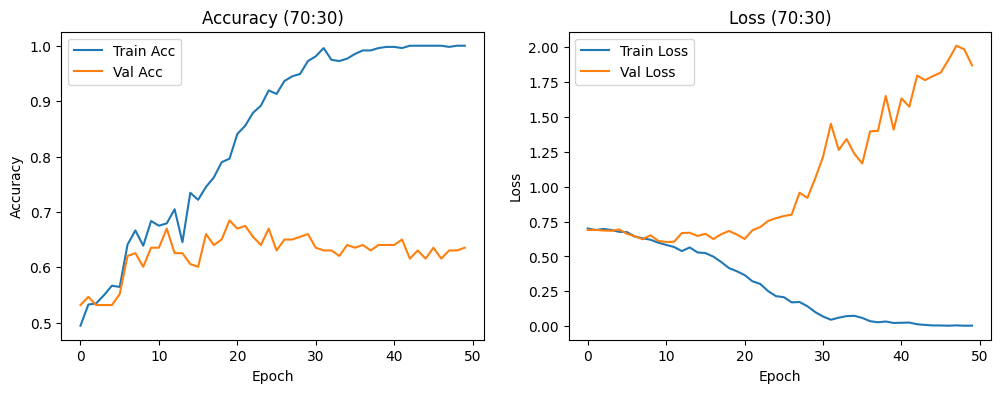

In [65]:
# === Visualization (70:30) ===
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_70.history["accuracy"], label="Train Acc")
plt.plot(history_70.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy (70:30)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_70.history["loss"], label="Train Loss")
plt.plot(history_70.history["val_loss"], label="Val Loss")
plt.title("Loss (70:30)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


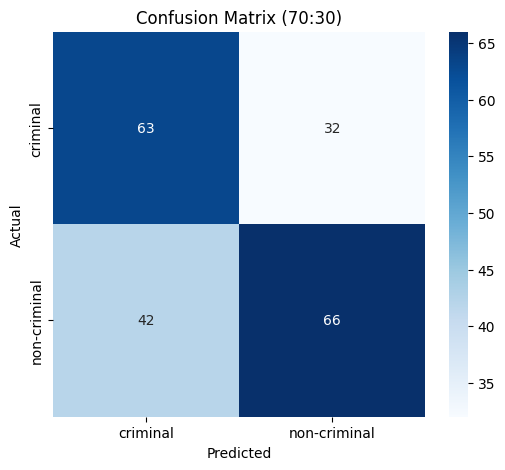

📊 Classification Report (70:30):

              precision    recall  f1-score   support

    criminal       0.60      0.66      0.63        95
non-criminal       0.67      0.61      0.64       108

    accuracy                           0.64       203
   macro avg       0.64      0.64      0.64       203
weighted avg       0.64      0.64      0.64       203



In [64]:

# Confusion Matrix
y_pred_probs_70 = model_70.predict(X_test_30)
y_pred_70 = np.argmax(y_pred_probs_70, axis=1)
y_true_70 = np.argmax(y_test_30, axis=1)

cm_70 = confusion_matrix(y_true_70, y_pred_70)

plt.figure(figsize=(6,5))
sns.heatmap(cm_70, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (70:30)")
plt.show()

print("📊 Classification Report (70:30):\n")
print(classification_report(y_true_70, y_pred_70, target_names=categories))

## Training Model (CNN) -> 80:20

In [67]:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    all_images, all_labels_cat, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Train shape (80%): {X_train_80.shape}, Test shape (20%): {X_test_20.shape}")

Train shape (80%): (539, 64, 64, 1), Test shape (20%): (135, 64, 64, 1)


In [68]:
model_80 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_80.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_80.summary()

c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history_80 = model_80.fit(
    X_train_80, y_train_80,
    validation_data=(X_test_20, y_test_20),
    epochs=50,
    batch_size=32,
    verbose=1
)

loss_80, acc_80 = model_80.evaluate(X_test_20, y_test_20, verbose=0)
print(f"✅ Test Accuracy (80:20): {acc_80:.4f}")

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5176 - loss: 0.7017 - val_accuracy: 0.5333 - val_loss: 0.6896
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5343 - loss: 0.6926 - val_accuracy: 0.5333 - val_loss: 0.6921
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5325 - loss: 0.6898 - val_accuracy: 0.5333 - val_loss: 0.6917
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5362 - loss: 0.6812 - val_accuracy: 0.5333 - val_loss: 0.6749
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5659 - loss: 0.6605 - val_accuracy: 0.5926 - val_loss: 0.6593
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5993 - loss: 0.6478 - val_accuracy: 0.6000 - val_loss: 0.6548
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6382 - loss: 0.6338 - val_accuracy: 0.5630 - val_loss: 0.6748
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6364 - loss: 0.6233 - val_accuracy: 0.5778 - v

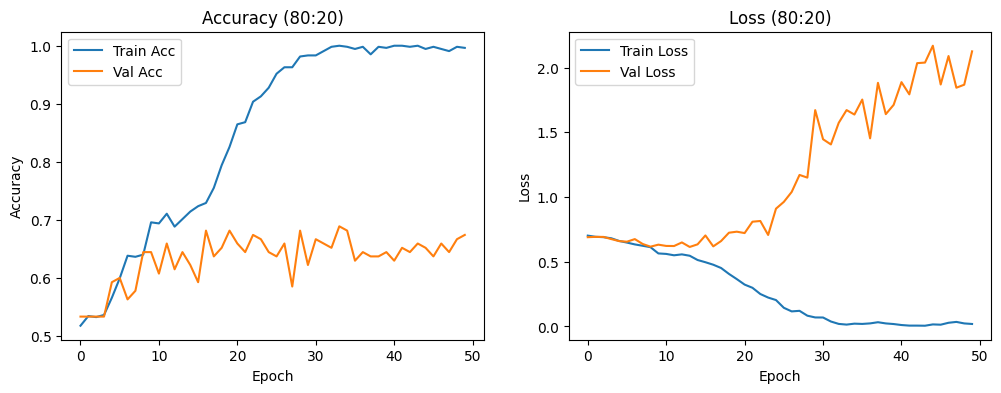

In [70]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_80.history["accuracy"], label="Train Acc")
plt.plot(history_80.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy (80:20)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_80.history["loss"], label="Train Loss")
plt.plot(history_80.history["val_loss"], label="Val Loss")
plt.title("Loss (80:20)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


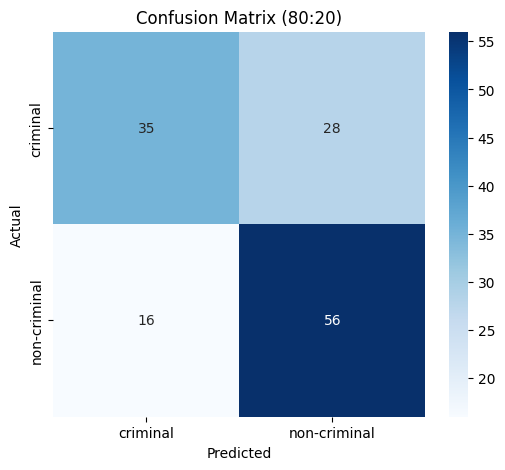

In [72]:
# Confusion Matrix
y_pred_probs_80 = model_80.predict(X_test_20)
y_pred_80 = np.argmax(y_pred_probs_80, axis=1)
y_true_80 = np.argmax(y_test_20, axis=1)

cm_80 = confusion_matrix(y_true_80, y_pred_80)

plt.figure(figsize=(6,5))
sns.heatmap(cm_80, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (80:20)")
plt.show()

In [73]:
print("📊 Classification Report (80:20):\n")
print(classification_report(y_true_80, y_pred_80, target_names=categories))

📊 Classification Report (80:20):

              precision    recall  f1-score   support

    criminal       0.69      0.56      0.61        63
non-criminal       0.67      0.78      0.72        72

    accuracy                           0.67       135
   macro avg       0.68      0.67      0.67       135
weighted avg       0.68      0.67      0.67       135



## Training Model (CNN) -> 90:10

In [74]:
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    all_images, all_labels_cat, test_size=0.1, random_state=42, stratify=all_labels
)

print(f"Train shape (90%): {X_train_90.shape}, Test shape (10%): {X_test_10.shape}")

Train shape (90%): (606, 64, 64, 1), Test shape (10%): (68, 64, 64, 1)


In [75]:
model_90 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_90.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_90.summary()

c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
history_90 = model_90.fit(
    X_train_90, y_train_90,
    validation_data=(X_test_10, y_test_10),
    epochs=50,
    batch_size=32,
    verbose=1
)

loss_90, acc_90 = model_90.evaluate(X_test_10, y_test_10, verbose=0)
print(f"✅ Test Accuracy (90:10): {acc_90:.4f}")

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5248 - loss: 0.6947 - val_accuracy: 0.5294 - val_loss: 0.6886
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5248 - loss: 0.6900 - val_accuracy: 0.5294 - val_loss: 0.6844
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5462 - loss: 0.6830 - val_accuracy: 0.6324 - val_loss: 0.6778
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5957 - loss: 0.6811 - val_accuracy: 0.5441 - val_loss: 0.6729
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6205 - loss: 0.6439 - val_accuracy: 0.5882 - val_loss: 0.6634
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6056 - loss: 0.6578 - val_accuracy: 0.5882 - val_loss: 0.6922
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6436 - loss: 0.6079 - val_accuracy: 0.5735 - val_loss: 0.6689
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6667 - loss: 0.6030 - val_accuracy: 0.5441 - v

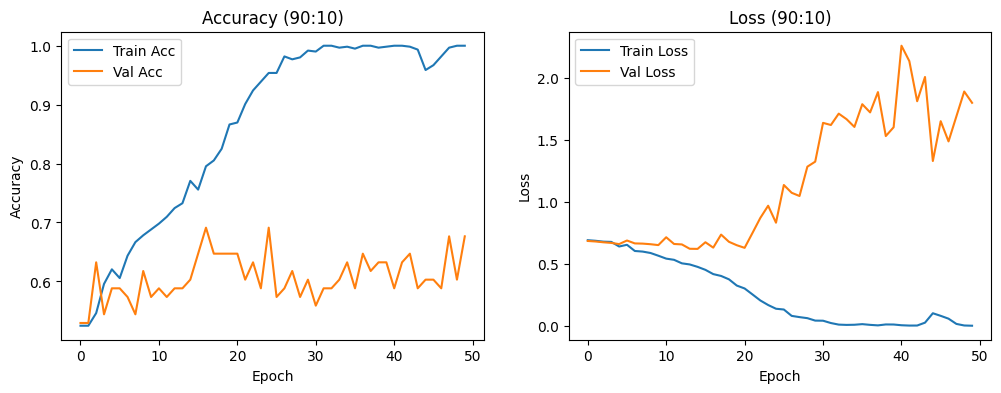

In [77]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_90.history["accuracy"], label="Train Acc")
plt.plot(history_90.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy (90:10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_90.history["loss"], label="Train Loss")
plt.plot(history_90.history["val_loss"], label="Val Loss")
plt.title("Loss (90:10)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


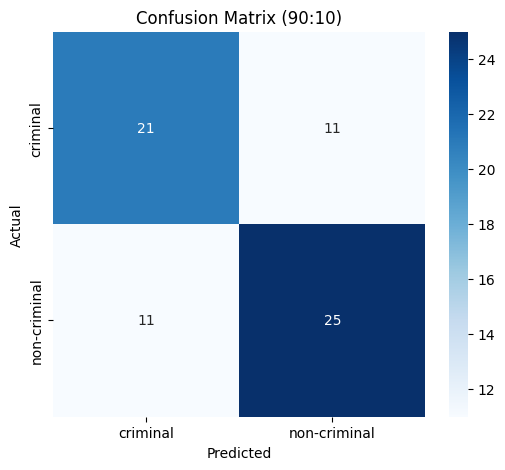

In [78]:
# Confusion Matrix
y_pred_probs_90 = model_90.predict(X_test_10)
y_pred_90 = np.argmax(y_pred_probs_90, axis=1)
y_true_90 = np.argmax(y_test_10, axis=1)

cm_90 = confusion_matrix(y_true_90, y_pred_90)

plt.figure(figsize=(6,5))
sns.heatmap(cm_90, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (90:10)")
plt.show()

In [79]:
# Classification Report
print("📊 Classification Report (90:10):\n")
print(classification_report(y_true_90, y_pred_90, target_names=categories))

📊 Classification Report (90:10):

              precision    recall  f1-score   support

    criminal       0.66      0.66      0.66        32
non-criminal       0.69      0.69      0.69        36

    accuracy                           0.68        68
   macro avg       0.68      0.68      0.68        68
weighted avg       0.68      0.68      0.68        68



## Save model

In [ ]:
# model.save("model/criminal_classifier_40Labels.h5")
# print("✅ Model saved!")

✅ Model saved!
